# Web Scraping and Data Visualisation using pandas and matplotlib

The task is to download data from server https://www.psp.cz/en/sqw/hlasovani.sqw?o=8 regarding voting in the Chamber of Deputies of the Parliament of the Czech Republic, save it in a tabular form and create visualisations, which make exploration of the data easier and show interesting information about it.

This notebook was submitted as a homework for (BIE-VZD) Data Mining course, while I was studying at Faculty of Information Technoloogies of Czech Technical University in Prague.


## Part 1. Getting the data.

I use BeautifulSoup and requests Python modules to parse html pages. After thorough analysis of the website, I noticed that *phlasa.sqw* file contains records of all votings, when specifying o=8 it returns votings from 2017. There are 350 pages containing votings from 2017 up to 2020. Let's define a function to parse these pages, and get links to all votings we need.

In [1]:
# First, import the needed modules
import requests
import time
import re
import concurrent.futures
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [23]:
votings = [] #this list will contain links to votings

def get_votings_from_page(n):
    url = f"https://public.psp.cz/en/sqw/phlasa.sqw?o=8&l=en&pg={n}"
    page = requests.get(url)
    soup = BeautifulSoup(page.text,'html.parser')

    for row in soup.table.find_all('tr'):
        if row.get('class') !=  None:
            continue
        cells = row.find_all('td')
        v = "https://public.psp.cz/en/sqw/" + cells[1].find('a').get('href')
        
        #these are the links to votings that do not contain data we need
        if v in ["https://public.psp.cz/en/sqw/hlasy.sqw?g=68539&l=en",
                    "https://public.psp.cz/en/sqw/hlasy.sqw?g=68540&l=en",
                    "https://public.psp.cz/en/sqw/hlasy.sqw?g=68541&l=en"]:
            continue
        votings.append(v)
        
def get_votings():
    with concurrent.futures.ThreadPoolExecutor(max_workers=100) as executor:
            executor.map(get_votings_from_page, range(1,350+1))

The first function above gets the links from one page. The get_votings() function parses all 350 pages. I use multithreading for a better performance. The iterative approach took ~3min to parse all 350 pages, while my approach made it in under 30sec. Now to parsing the links:

In [24]:
def parse_page(url):
    result = []

    page = requests.get(url)
    soup = BeautifulSoup(page.text,'html.parser')

    # get voting info: meeting number, voting number, topic, and date
    voting_info = soup.find('h1',class_="page-title-x").text
    pattern = "(\d+)\.\s\w+,\s(\d+)\.\s\w+,\s(\d+\.\s\w+\s(\d+),\s\d+:\d\d)([\w\s\.]*)"
    rgx = re.search(pattern,voting_info)
    meeting = rgx.group(1)
    voting = rgx.group(2)
    date = rgx.group(3)
    date = date.replace('\xa0',' ')
    date = date.replace(',','')
    year = int(rgx.group(4))

    # get parties info, namely their titles
    parties = soup.find('div',{"id": "main-content"}).find_all('ul')
    party_names = soup.find_all('h2',class_="section-title center")
    party_titles = []

    for party in party_names:
        party_name = party.find('span').text
        party_name = re.search("[\w-]+",party_name).group(0)
        party_titles.append(party_name)
    party_titles = party_titles[1:-1]

    j = 0

    # parse individual members, and assign their parties to them
    for party in parties:
        people = party.find_all('li')
        for i in people:
            i = str(i.text)
            pattern = "(\w+) ([\w\s]+)"
            i = re.search(pattern,i)
            vote = i.group(1)
            name = i.group(2)
            l = []
            name = name.replace('\xa0',' ')
            l.append(name)
            l.append(vote)
            l.append(party_titles[j])
            l.append(meeting)
            l.append(voting)
            l.append(date)
            l.append(year)
            result.append(l)
        j+=1

    # write to data.csv file
    with open('data.csv', 'a') as f:
        for r in result:
            f.write(f"{r[0]},{r[1]},{r[2]},{r[3]},{r[4]},{r[5]},{r[6]}\n")
    
    # wait for 250ms, because we are nice to the Parliament's server
    time.sleep(0.25)

The function above is very simple. It parses the voting page, gets the information about voting, extracts individual parliament members, and assigns them their respective party title, and their votes (or absence, if they did not vote).

Now, let's run this all:

In [ ]:
get_votings()

#write the headers
with open('data.csv', 'w') as f:
    f.write("Name,Vote,Party,Meeting,Voting,VotingDate,Year\n")

#Initiate our timer, just to check how long it took to get the data
start = time.time()

#Specify number of threads
threads = 100
with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
        executor.map(parse_page, votings)

end = time.time()
print("Done! Time elapsed:",(end-start)//60,'min',(end-start)%60,'sec')

Above we can see again the multithreading approach to parse all votings. There are approximately 7000 of them, which, for iterative solution, it took ~59 minutes on average depending on the internet connection. My solution did the job in ~8 minutes.

In fact, we can do it even better. The number of "workers" specified is 100, though if we play around with the number of threads, we can achieve the golden mean. Did not focus on this for now.

Of course, the data.csv file comes with this notebook, but you can run the code yourself as well.

## Part 2. Visualizing the data.

### 2.1. Deputies changing their parliamentary clubs.

In [193]:
df = pd.read_csv('data.csv')

In [190]:
# get list of people who changed parties throughout 2017-2020
d = df.groupby('Name').nunique()
people = list(d[d.Party > 1].index.values)
parties = []

for person in people:
    persons_parties = []
    for i in range(2017,2021):
        persons_parties.append(df[(df.Name == person) & (df.Year == i)].Party.unique().tolist()[0])
    parties.append(persons_parties)

people_parties = dict(zip(people,parties))

The people who have changed their parties (or became independent ("Nezařaz")) throught the 4 years are stored in *people_parties* dictionary. Now, let's visualize this:

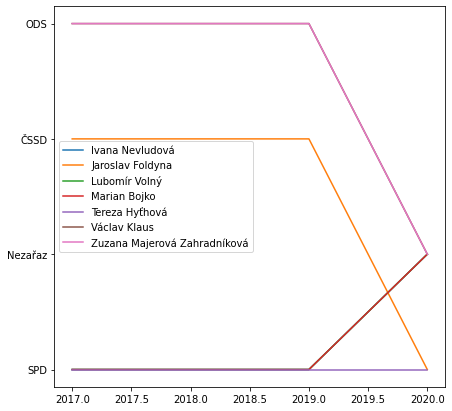

In [192]:
#set up the plot

year = [2017,2018,2019,2020]

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)

for i in people_parties:    
    ax.plot(year,people_parties[i],label=i)


ax.legend(loc='best')
#  
plt.show()

### 2.2. Attendance of parliamentary clubs in the votings.

In [94]:
#get list of parties
parties = df['Party'].drop_duplicates().tolist()

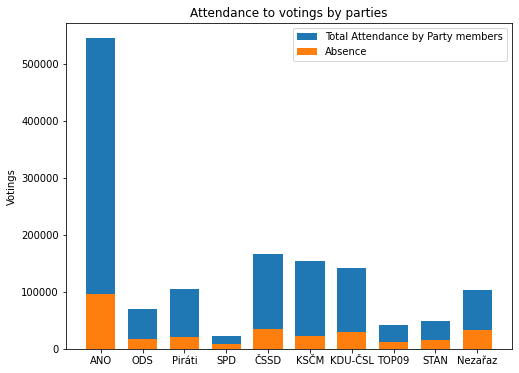

In [19]:
#get number of attendance and absences
total = df.groupby('Party').count()['Voting']
absence = df[((df.Vote == '0') | (df.Vote == 'M'))].groupby('Party').count()['Voting']

#set p the plot
labels = parties
total = total.tolist()
absence = absence.tolist()

men_std = [2, 3, 4, 1, 2]
women_std = [3, 5, 2, 3, 3]
width = 0.7      # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(8)

ax.bar(labels, total, width, label='Total Attendance by Party members')
ax.bar(labels, absence, width,label='Absence')

ax.set_ylabel('Votings')
ax.set_title('Attendance to votings by parties')
ax.legend()

plt.show()

###  Attendance of individual deputies in the votings.

In [30]:
deputies = df['Name'].drop_duplicates().tolist()

In [18]:
total = []

for deputy in deputies:
    abss = len(df[(df.Name == deputy) & ((df.Vote == '0') | (df.Vote == 'M'))].index)
    total_att = len(df[(df.Name == deputy)].index)
    percentage = (total_att - abss) * 100 / total_att
    total.append(percentage)

We can find the average attendance of all deputies, but this won't give us the real "average", as there are some deputies who tend to miss most of the votings. So, let's find the median attendance, as well:

In [19]:
avg = sum(total) / len(total)

median = pd.Series(total).median()

print("Average attendance:",avg)
print("Median attendance: ",median)

Average attendance: 78.9533376815112
Median attendance:  80.1432664756447


Let us see who are those deputies, whose attendance is, say, less than 60%.

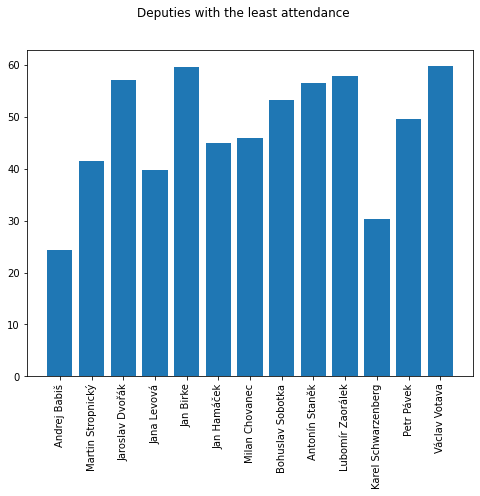

In [29]:
#filter those whose attendance is below 60%
mapping = dict(zip(deputies,total))      
mapping = dict(filter(lambda x: x[1] < 60, mapping.items()))


names = list(mapping.keys())
values = list(mapping.values())

fig, axs = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(8)
plt.xticks(rotation='vertical')

axs.bar(names, values)

fig.suptitle('Deputies with the least attendance')

plt.show()

As we can see, Prime Minister Andrej Babiš does not really have time to vote for the new bills.

### Task 2.3. How often individual parliamentary clubs vote the same and different.

Let us take a look at how overall voting for ANO party changed throughout years:

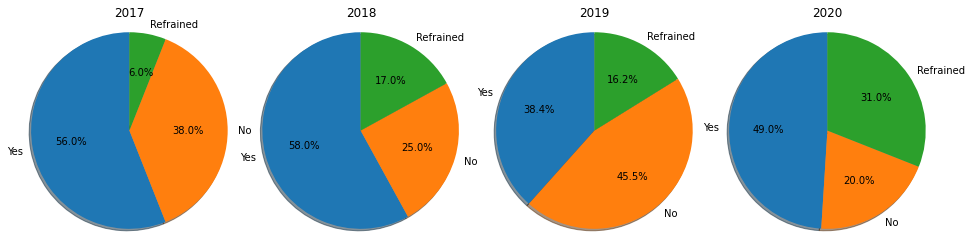

In [90]:
def show_votings(party):

    results = {
        2017: [],
        2018: [],
        2019: [],
        2020: []
    }

    for i in range(2017,2021):
        yes = len(df[(df.Party == party) & (df.Year == i) & (df.Vote == "A")].index)
        no = len(df[(df.Party == party) & (df.Year == i) & (df.Vote == "N")].index)
        refrain = len(df[(df.Party == party) & (df.Year == i) & (df.Vote == "Z")].index)
        total = yes + no + refrain
        results[i].append(round(yes * 100 / total))
        results[i].append(round(no * 100 / total))
        results[i].append(round(refrain * 100 / total))
        
    #set up plot
    labels = 'Yes', 'No', 'Refrained'

    fig1, axs = plt.subplots(1,4,figsize=(16, 4), sharey=True)


    for i in range(2017,2021):
        axs[i-2017].pie(results[i], labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
        axs[i-2017].axis('equal')
        axs[i-2017].set_title(i)

    plt.show()
    
show_votings("ANO")

Same statistics for party TOP 09:

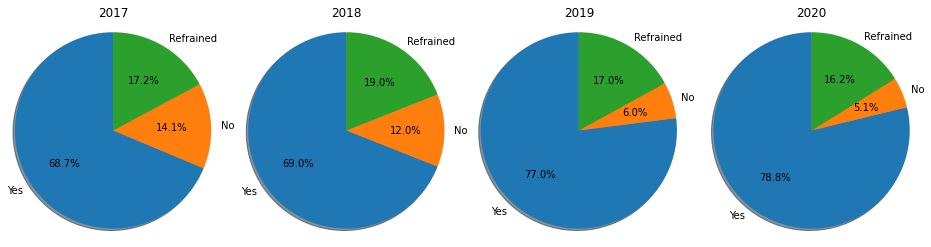

In [99]:
show_votings("TOP09")

### 2.4. Who are the biggest rebels?

Let's see who votes against proposed laws most of all in each party:

In [195]:
def show_rebels(party):

    nos = df[(df.Party == party) & (df.Vote=='N')].groupby('Name').count()['Voting'].nlargest(10)
    people = list(nos.index.values)
    total = []

    for i in people:
        total.append(int(df[(df.Party == party) & (df.Name==i)].groupby('Name').count()['Voting'].values))
    
    percentage = zip(nos,total)
    percentage = [str(round(x*100 / y,1))+'%' for (x,y) in percentage]

    tmp = nos.to_frame()
    tmp.insert(1,'Percentage',percentage)
    return tmp

The function above returns a dataframe of 10 people who voted against in most number of votings. For party ANO the rebels are:

In [196]:
rebels = show_rebels("ANO")
rebels

,Voting,Percentage
Name,,
Milan Feranec,2525,36.2%
Stanislav Berkovec,2427,34.8%
Marek Novák,2401,34.4%
Jaroslav Kytýr,2383,34.1%
Marcela Melková,2329,33.4%
Monika Oborná,2327,33.3%
Jiří Strýček,2323,33.3%
Barbora Kořanová,2322,33.3%
Roman Kubíček,2302,33.0%
